# 第6章 函数式对象
有了前几章对Scala基础的理解，你已经准备好用Scala设计更多功能、更完整的类。本章的重点是那些定义函数式对象的类，或者那些没有任何可变状态的对象。作为例子，我们将创建一个以不可变对象对有理数建模的类的若干版本。在这个过程中，我们将向你展示关于Scala面向对象编程的更多知识：类参数和构造方法、方法和操作符、私有成员、重写、前置条件检查、重载，以及自引用。 
## 6.1 Rational类的规格定义  
有理数（rational number）是可以用比例n/d表示的数，其中n和d是整数，但d不能为0。n称作分子（numerator）而d称作分母（denominator）。典型的有理数如：1/2,2/3,112/239,2/1等。跟浮点数相比，有理数的优势是小数是精确展现的，而不会舍入或取近似值。

我们在本章要设计的类将对有理数的各项行为进行建模，包括允许它们被加、减、乘、除。要将两个有理数相加，首先要得到一个公分母，然后将分子相加。例如，要计算1/2+2/3，你会将左操作元的分子和分母分别乘以3，将右操作元的分子和分母分别乘以2，得到3/6+4/6，再将两个分子相加，得到7/6。要将两个有理数相乘，可以简单地将它们的分子和分母相乘。因此，(1/2)\*(2/5)得到2/10，这个结果可以被更紧凑地表示为正规化（normalized）的1/5。有理数的除法是将右操作元的分子分母对调，然后做乘法。例如，(1/2)/(3/5)等于(1/2)\*(5/3)，即5/6。

另一个（可能比较细微的）观察是，数学中有理数没有可变的状态。可以将一个有理数跟另一个相加，但结果是一个新的有理数，原始的有理数并不会“改变”。我们在本章要设计的不可变的Rational类也满足这个性质。每一个有理数都会有一个Rational对象来表示。当你把两个Rational对象相加时，你将会创建一个新的Rational对象来持有它们的和。

在本章你会看到Scala提供给你用来编写类库的一些手段，它们感觉就像是语言原生支持的那样。例如，读完本章你将可以这样使用Rational类：
 
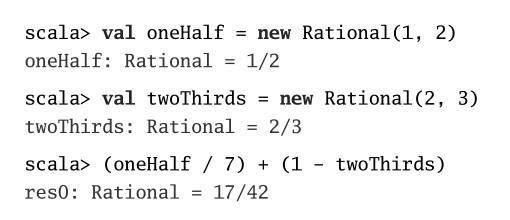

## 6.2 构建Rational
要定义Rational类，首先可以考虑一下使用者如何创建新的Rational对象。由于已经决定Rational对象是不可变的，将要求使用者在构造Rational实例的时候就提供所有需要的数据（也就是分子和分母）。因此，我们从如下的设计开始：

In [ ]:
class Rational(n:Int,d:Int)

关于这段代码，首先要注意的一点是如果一个类没有定义体，并不需要给出空的花括号（只要你想，当然也可以）。类名Rational后的圆括号中的标识符n和d称作类参数（class parameter）。Scala编译器将会采集到这两个类参数，并且创建一个主构造方法（primary constructor），接收同样的这两个参数。

**不可变对象的设计取舍**  
跟可变对象相比，不可变对象具有若干优势和一个潜在的劣势。首先，不可变对象通常比可变对象更容易推理，因为它们没有随着时间变化而变化的复杂的状态空间。其次，可以相当自由地传递不可变对象，而对于可变对象，在传递给其他代码之前，你可能需要对它们做保护式的拷贝。再次，假如有两个并发的线程同时访问某个不可变对象，它们没有机会在对象正确构造以后破坏其状态，因为没有线程可以改变某个不可变对象的状态。最后，不可变对象可以被安全地用作哈希表里的键。举例来说，如果某个可变的对象在被加到HashSet以后被改变了，当你下次再检索该HashSet的时候，你可能就找不到这个对象了。  
不可变对象的主要劣势是它们有时候会需要拷贝一个大的对象图，而实际上也许一个局部的更新也能满足要求。在某些场景下，不可变对象可能用起来比较别扭，同时还带来性能瓶颈。因此，类库对于不可变的类也提供可变的版本这样的做法并不罕见。例如， StringBuilder类就是对不可变的String类的一个可变的替代。我们将在第18章更详细地介绍Scala中可变对象的设计。

**注意**  
这个Rational示例突出显示了Java和Scala的一个区别。在Java中，类有构造方法，构造方法可以接收参数；而在Scala中，类可以直接接收参数，Scala的表示法更为精简（类定义体内可以直接使用类参数，不需要定义字段并编写将构造方法参数赋值给字段的代码）。这可以大幅节省样板代码，尤其对于小型的类而言。
Scala编译器会将你在类定义体中给出的非字段或方法定义的代码编译进类的主构造方法中。举例来说，可以像这样来打印一条调试消息：
 
对这段代码，Scala编译器会将println调用放在Rational的主构造方法中。这样一来，每当你创建一个新的Rational实例时，都会触发println打印出相应的调试消息：

In [ ]:
class Rational(n: Int, d: Int){
    println("Created " + n + "/" + d)
}
new Rational(1,2)

## 6.3 重新实现toString方法
当我们在前一例中创建Rational实例时，解释器打印了“Rational@90110a”。解释器是通过对Rational对象调用toString来获取到这个看上去有点奇怪的字符串的。Rational类默认继承了java.lang.Object类的toString实现，这个实现只是简单地打印出类名、@符和一个十六进制的数字。toString的主要意图是帮助程序员在调试输出语句、日志消息、测试失败报告，以及解释器和调试器输出中给出相应的信息。目前由toString提供的结果并不特别有帮助，因为它没有给出关于有理数的值的任何线索。一个更有用的toString实现可能是打印出Rational的分子和分母。可以通过给Rational类添加toString方法来重写（override）默认的实现，就像这样：

In [ ]:
class Rational(n: Int, d: Int){
    override def toString = n + "/" + d
}
new Rational(1,2)

在方法定义之前的override修饰符表示前一个方法定义被重写覆盖了（第10章有更多相关内容）。由于Rational（有理数）现在可以漂亮地显示了，我们移除了先前版本的Rational中那段用于调试的println语句。可以在解释器中测试Rational的新行为：

In [ ]:
val x = new Rational(1,3)
val y = new Rational(5,7)
val z = new Rational(5,0)

## 6.4 检查前置条件
接下来，我们将注意力转向当前主构造方法的一个问题。在本章最开始我们曾经提到，有理数的分母不能为0。而目前我们的主构造方法接收以d传入的0：



In [ ]:
val z = new Rational(5,0)

面向对象编程的一个好处是可以将数据封装在对象里，以确保整个生命周期中数据都是合法的。对于Rational这样的不可变对象而言，这意味着需要确保对象在构造时数据合法。由于对于Rational数来说分母为0是非法的状态，当0作为参数d传入的时候，不应该允许这样的Rational被创建出来。
解决这个问题的最佳方式是对主构造方法定义一个前置条件（precondition）， d必须为非0值。前置条件是对传入方法或构造方法的值的约束，这是方法调用者必须要满足的。实现这个的一种方式是用require,[1]就像这样：

In [ ]:
class Rational(n: Int, d: Int){
    require(d != 0)
    override def toString = n + "/" + d
}
new Rational(1,2)
new Rational(1,0)

require方法接收一个boolean的参数。如果传入的参数为true, require将会正常返回。否则，require将会抛出IllegalArgumentException来阻止对象的构建。

## 6.5 添加字段
现在主构造器已经正确地保证了它的前置条件，我们将注意力转向如何支持加法。我们将给Rational类定义一个add方法，接收另一个Rational作为参数。为了保持Rational不可变，这个add方法不能将传入的有理数加到自己身上，它必须创建并返回一个新的持有这两个有理数的和的Rational对象。你可能会认为这样写add是OK的：

In [ ]:
class Rational(n: Int, d: Int){
    require(d != 0)
    override def toString = n + "/" + d
    def add(that: Rational): Rational =
        new Rational(n*that.d + that.n*d, d * that.d)
}

虽然类参数n和d在你的add方法中是在作用域内的，只能访问执行add调用的那个对象上的n和d的值。因此，当你在add实现中用到n或d时，编译器会提供这些类参数对应的值，但它并不允许使用that.n或that.d，因为that并非指向你执行add调用的那个对象。[2]要访问that的分子和分母，需要将它们做成字段。示例6.1展示了如何将这些字段添加到Rational类。[3]

在示例6.1的这个Rational版本中，我们添加了两个字段，numer和demon，分别用类参数n和d的值初始化。[4]我们还修改了toString和add方法的实现，使用这两个字段，而不是类参数。这个版本能够编译通过。可以拿有理数做加法来测试它：

In [ ]:
class Rational(n: Int, d: Int){
    require(d != 0)
    val number: Int = n
    val denom: Int = d
    override def toString = number + "/" + denom
    def add(that: Rational): Rational =
        new Rational(number*that.denom + that.number*denom, denom * that.denom)
}

In [ ]:
val oneHalf = new Rational(1, 2)
val twoThirds = new Rational(2, 3)
oneHalf add twoThirds

还有另一个你之前不能做但现在可以做的事，那就是从对象外部访问分子和分母的值。只需要访问公共的numer和demon字段即可，就像这样：

In [ ]:
val r = new Rational(1, 2)
r.number
r.denom

## 6.6 自引用
关键字this指向当前执行方法的调用对象，当被用在构造方法里的时候，指向被构造的对象实例。举例来说，我们可以添加一个lessThan方法，来测试给定的Rational是否小于某个传入的参数：

In [ ]:
class Rational(n: Int, d: Int){
    require(d != 0)
    val number: Int = n
    val denom: Int = d
    override def toString = number + "/" + denom
    def add(that: Rational): Rational =
        new Rational(number*that.denom + that.number*denom, denom * that.denom)
    def lessThan(that: Rational) = 
        this.number*that.denom < that.number*this.denom
}

在这里，this.numer指向执行lessThan调用的对象的分子。也可以省去this前缀，只写numer。这两种表示法是等效的。

再举个不能省去this的例子，假定我们要给Rational添加一个max方法，返回给定的有理数和参数之间较大的那个：

In [ ]:
class Rational(n: Int, d: Int){
    require(d != 0)
    val number: Int = n
    val denom: Int = d
    override def toString = number + "/" + denom
    def add(that: Rational): Rational =
        new Rational(number*that.denom + that.number*denom, denom * that.denom)
    def lessThan(that: Rational) = 
        this.number*that.denom < that.number*this.denom
    def max(that: Rational) = 
        if(this.lessThan(that)) that else this
}

在这里，第一个this是冗余的。完全可以不写this，直接写lessThan（that）。但第二个this代表了当测试返回false时该方法的结果；如果不写this，就没有可返回的结果了！

## 6.7 辅助构造方法
有时需要给某个类定义多个构造方法。在Scala中，主构造方法之外的构造方法称为辅助构造方法（auxiliary constructor）。例如，一个分母为1的有理数可以被更紧凑地直接用分子表示，比如5/1可以简单地写成5。因此，如果Rational的使用方可以直接写Rational（5）而不是Rational（5, 1），可能是件好事。这需要我们给Rational添加一个额外的辅助构造方法，只接收一个参数，即分子，而分母被预定义为1。示例6.2给出了代码。

**Scala的辅助构造方法以def this（...）开始。**Rational的辅助构造方法的方法体只是调用一下主构造方法，透传它唯一的参数n作为分子，1作为分母。可以在解释器中键入如下代码来实际观察辅助构造方法的执行效果：
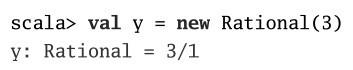

In [ ]:
class Rational(n: Int, d: Int){
    require(d != 0)
    val number: Int = n
    val denom: Int = d
    def this(n: Int) = this(n,1) //auxiliary constructor辅助构造方法
    override def toString = number + "/" + denom
    def add(that: Rational): Rational =
        new Rational(number*that.denom + that.number*denom, denom * that.denom)
    def lessThan(that: Rational) = 
        this.number*that.denom < that.number*this.denom
    def max(that: Rational) = 
        if(this.lessThan(that)) that else this
}

在Scala中，每个辅助构造方法都必须首先调用同一个类的另一个构造方法。换句话说，Scala每个辅助构造方法的第一条语句都必须是这样的形式：“this（...）”。**被调用的这个构造方法要么是主构造方法（就像Rational示例那样），要么是另一个出现在发起调用的构造方法之前的另一个辅助构造方法。这个规则的净效应是Scala的每个构造方法最终都会调用到该类的主构造方法。这样一来，主构造方法就是类的单一入口。**

**注意**  
如果你熟悉Java，你可能会好奇为什么Scala的构造方法规则比Java更严格。在Java中，构造方法要么调用同一个类的另一个构造方法，要么直接调用超类的构造方法。而在Scala类中，只有主构造方法可以调用超类的构造方法。Scala这个增强的限制实际上是一个设计的取舍，用来换取更精简的代码和跟Java相比更为简单的构造方法。我们将会在第10章详细介绍超类，以及构造方法和继承的相互作用。

## 6.8 私有字段和方法
在前一版Rational中，我们只是简单地用n和d分别初始化了numer和denon。因此，一个Rational的分子和分母可能会比需要的更大。比如，分数66/42可以被正规化成等效的化简格式11/7，但Rational的主构造方法目前并没有这样处理：

In [ ]:
new Rational(66, 42)

要做到正规化，需要对分子和分母分别除以它们的最大公约数（greatest common divisor）。比如66和42的最大公约数是6。（换句话说，6是可以同时整除66和42的最大整数）。对66/42的分子和分母同时除以6，得到化简的11/7。示例6.3展示了一种实现方式：

In [ ]:
class Rational(n: Int, d: Int){
    require(d != 0)
    private val g = gcd(n.abs, d.abs)
    val number: Int = n/g
    val denom: Int = d/g
    def this(n: Int) = this(n,1) //auxiliary constructor辅助构造方法
    override def toString = number + "/" + denom
    def add(that: Rational): Rational =
        new Rational(number*that.denom + that.number*denom, denom * that.denom)
    def lessThan(that: Rational) = 
        this.number*that.denom < that.number*this.denom
    def max(that: Rational) = 
        if(this.lessThan(that)) that else this
    private def gcd(a: Int, b: Int): Int = 
        if(b==0) a else gcd(b, a%b)
}

在这个版本的Rational中，我们添加了一个私有的字段g，并修改了numer和denom的初始化器（初始化器是初始化某个变量的代码。例如，用来初始化numer的“n / g”）。由于g是私有的，我们只能从类定义内部访问它，从外面访问不到。我们还添加了一个私有方法gcd，计算传入的两个Int参数的最大公约数。比如gcd（12, 8）返回4。正如你在4.1节看到的，要把一个字段或方法变成私有，只需要简单地在其定义之前加上private修饰符。这个私有的“助手方法”gcd的目的是将类的其他部分（在本例中是主构造方法）需要的代码抽取出来。为了确保g永远是正数，我们传入n和d的绝对值，取得绝对值的方式是对它们调用abs方法，可以在任何Int上调用abs来得到其绝对值。

Scala编译器会把Rational的三个字段的初始化器代码按照它们在代码中出现的先后次序编译进主构造方法中。也就是说，g的初始化器，gcd（n.abs, d.abs），会在另两个初始化器之前执行，因为在源码中它是第一个出现的。字段g会被初始化成该初始化器的结果，即类参数n和d的绝对值的最大公约数。接下来，字段g被用在numer和denom的初始化器当中。通过对n和d分别除以它们的最大公约数g，每个Rational都会被构造成正规化后的形式：

In [ ]:
new Rational(66, 42)

## 6.9 定义操作符
Rational目前实现的加法还算OK，但我们可以让它更好用。你可能会问自己，为什么对于整数或浮点数，可以写：
 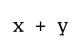
但对于有理数，必须写成：
 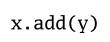
或者至少是：
 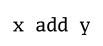
做成这样，并没有很有说服力的理由。有理数不过是跟其他数值一样。从数学意义上讲，它们甚至比浮点数来得更自然。为什么不用自然的算术操作符来操作它们呢？Scala允许你这样做。在本章的剩余部分，我们将向你展示如何做到。
第一步是将add替换成通常的那个数学符号。这个做起来很直截了当，因为在Scala中+是一个合法的标识符。可以简单地定义一个名为+的方法。在这么做的同时，完全可以顺手实现一个*方法，来执行乘法操作。结果如示例6.4：


In [ ]:
class Rational(n: Int, d: Int){
    require(d != 0)
    private val g = gcd(n.abs, d.abs)
    val number: Int = n/g
    val denom: Int = d/g
    def this(n: Int) = this(n,1) //auxiliary constructor辅助构造方法
    
    def + (that: Rational): Rational =
        new Rational(number*that.denom + that.number*denom, denom * that.denom)
    def * (that: Rational): Rational =
        new Rational(number*that.number, denom * that.denom)   
    def lessThan(that: Rational) = 
        this.number*that.denom < that.number*this.denom
    def max(that: Rational) = 
        if(this.lessThan(that)) that else this
    override def toString = number + "/" + denom
    
    private def gcd(a: Int, b: Int): Int = 
        if(b==0) a else gcd(b, a%b)
}

有了这样的Rational类，可以写出如下代码：

In [ ]:
val x = new Rational(1,2)
val y = new Rational(2,3)
x + y


跟平时一样，最后一行输入的操作符语法等同于方法调用。也可以写成：

In [ ]:
x.+(y)

不过这并不是那么可读。

另一个值得注意的点是，按照Scala的操作符优先级（在5.9节介绍过），对于Rational来说，*方法会比+方法绑得更紧。换句话说，涉及Rational的+和*操作，其行为会按照我们预期的那样。比如，x + x * y 会被当作 x+ （x * y）执行，而不是（x + x） * y：

In [ ]:
x + x * y
(x + x) * y
x + (x * y)

## 6.10 Scala中的标识符
至此，你已经看到了Scala中构成标识符的两种最重要的形式：字母数字组合，以及操作符。Scala对于标识符有着非常灵活的规则。除了你见过的这两种之外，还有另外两种。本节将介绍标识符的所有四种构成形式。

字母数字组合标识符（alphanumeric identifier）以字母或下画线打头，可以包含更多的字母、数字或下画线。字符“$”也算作字母；不过，它预留给那些由Scala编译器生成的标识符。

Scala遵循了Java使用驼峰命名法（camel-case）[5]命名标识符的传统，比如toString和HashSet。虽然下画线是合法的标识符，它们在Scala程序中并不常用，其中一部分原因是跟Java保持一致，不过另一个原因是下画线在Scala代码中还有许多其他非标识符的用法。因为上述的原因，最好不去使用像to_string、__init__或name_这样的标识符。字段、方法参数、局部变量和函数的驼峰命名应该以小写字母打头，比如length、flatMap和s等。类和特质的驼峰命名应该以大写字母打头，例如BigInt、List和UnbalancedTreeMap等。[6]

**注意**  
在标识符的末尾使用下画线的一个后果是，如果你像这样来声明一个变量：“val name_: Int = 1”，你会得到一个编译错误。编译器会认为你要声明的变量名称是“name_:”。要让这段代码通过编译，需要在分号前额外插入一个空格，就像这样：“val name_ : Int = 1”。

在常量命名上，Scala的习惯跟Java不同。在Scala中，常量（constant）这个词并不仅仅意味着val。虽然val在初始化之后确实不会变，但它仍然是个变量。举例来说，方法参数是val，但方法每次被调用时，这些val都可以拿到不一样的值。而一个常量则更永固。例如，scala.math.Pi被定义成最接近π （即圆周长和直径的比例）的双精度浮点数值。这个值不太可能会变化，因此，Pi显然是个常量。还可以用常量来表示代码中那些不这样做就会成为“魔数”（magic number）的值：即没有任何解释的字面量，最差的情况是其甚至出现多次。可能还会在模式匹配中用到常量，在15.2节将介绍一个具体的用例。Java对常量的命名习惯是全大写，并用下画线分隔开不同的单词，比如M A X_VALUE或PI。而Scala的命名习惯只要求首字母大写。因此，以Java风格命名的常量，比如X_OFFSET，在Scala中也可以正常工作，不过Scala的习惯是用驼峰命名法命名常量，比如XOffset。

操作标识符（operator identifier）由一个或多个操作字符构成。操作字符指的是那些可以被打印出来的ASCII字符，比如+、:、?、～、#等。[7]以下是一些操作标识符举例：
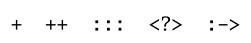
Scala编译器会在内部将操作标识符用内嵌\\$的方式转成合法的Java标识符。比如，:->这个操作标识符会在内部表示为\\$colon\\$minus\\$greater。如果你打算从Java代码中访问这些标识符，就需要使用这种内部形式。

**由于Scala的操作标识符支持任意长度**，Java跟Scala在这里有个细微的差异。在Java中，x<-y这样的代码会被解析成四个语法符号，等同于 x < - y。而在Scala中，<-会被解析成一个语法符号，所以给出的解析结果是 x <- y。如果你想要的效果是前一种，需要用空格将<和-分开。但这在实际使用中不太会成为问题，因为很少有人会在Java中连着写x<-y而不在中间加上空格或括号。

混合标识符（mixed identifier）由一个字母数字组合操作符、一个下画线和一个符号操作符组成。例如，unary_+这个表示+操作符的方法名，或者myvar_=这个表示赋值的方法名。除此之外，形如myvar_=这样的混合标识符也被Scala编译器用来支持属性（properties），更多内容详见第18章。

字面标识符（literal identifier）是用反引号括起来的任意字符串（\`...\`）。字面标识符举例如下：
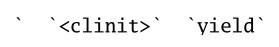

可以将任何能被运行时接收的字符串放在反引号当中，作为标识符。其结果永远是个（合法的）Scala标识符，甚至当反引号中的名称是Scala保留字（reserved word）时也生效。一个典型的用例是访问Java的Thread类的静态方法yield。不能直接写Thread.yield（），因为yield是Scala的保留字。不过，仍然可以在反引号中使用这个方法名，就像这样：Thread.\`yield\`（）。

## 6.11 方法重载
回到Rational类。有了最新的这些变更以后，可以用更自然的风格来对有理数进行加法和乘法。不过我们还缺少混合算术。比如，不能用一个有理数乘以一个整数，因为*的操作元必须都是Rational。因此对于一个有理数r，不能写r * 2，而必须写成r * new Rational（2），这并不是理想的效果。

要让Rational用起来更方便，我们将添加两个新的方法来对有理数和整数做加法和乘法。同时，还会顺便加上减法和除法。调整后的结果请看示例6.5。

现在每个算术方法都有两个版本：一个接收有理数作为参数，另一个则接收正数。换句话说，每个方法名都被“重载”（overload）了，因为每个方法名都被用于多个方法。举例来说，+这个方法名被同时用于一个接收Rational的方法和另一个接收Int的方法。在处理方法调用时，编译器会选取重载方法中正确匹配了入参类型的版本。例如，如果x.+（y）中的y是Rational，编译器会选择接收Rational参数的+方法。但如果入参是整数，编译器就会选择接收Int参数的那个方法。
你将会看到，被调用的*方法具体是哪一个，取决于右操作元的类型。

**注意**  
Scala解析重载方法的过程跟Java很像。在每个具体的案例中，被选中的是那个最匹配入参静态类型的重载版本。有时候并没有一个唯一的最佳匹配版本；遇到这种情况编译器会提示“ambiguous reference”（模糊引用）错误。

In [ ]:
class Rational(n: Int, d: Int){
    require(d != 0)
    private val g = gcd(n.abs, d.abs)
    val number: Int = n/g
    val denom: Int = d/g
    def this(n: Int) = this(n,1) //auxiliary constructor辅助构造方法
    
    def + (that: Rational): Rational =
        new Rational(number*that.denom + that.number*denom, denom * that.denom)
    def + (i: Int): Rational =
        new Rational(number + i*denom, denom)
    
    def - (that: Rational): Rational =
        new Rational(number*that.denom - that.number*denom, denom * that.denom)
    def - (i: Int): Rational =
        new Rational(number - i*denom, denom)    
    
    def * (that: Rational): Rational =
        new Rational(number*that.number, denom * that.denom)
    def * (i: Int): Rational =
        new Rational(number*i, denom)
    
    def / (that: Rational): Rational =
        new Rational(number*that.denom, denom * that.number)
    def / (i: Int): Rational =
        new Rational(number, denom * i)
    
    def lessThan(that: Rational) = 
        this.number*that.denom < that.number*this.denom
    def max(that: Rational) = 
        if(this.lessThan(that)) that else this
    override def toString = number + "/" + denom
    
    private def gcd(a: Int, b: Int): Int = 
        if(b==0) a else gcd(b, a%b)
}

val x =  new Rational(2, 3)
x * x
x * 2

## 6.12 隐式转换
现在你已经可以写r * 2，你可能还想交换两个操作元的位置，即2 * r。很不幸，这样还不行：

In [ ]:
2 * x

这里的问题是2 * r等价于2.*（r），因此这是一个对2这个整数的方法调用。但Int类并没有一个接收Rational参数的乘法方法—它没法有这样一个方法，因为Rational类并不是Scala类库中的标准类。
不过，Scala有另外一种方式来解决这个问题：可以创建一个隐式转换（implicit conversion），在需要时自动将整数转换成有理数。可以往解释器里添加行：


In [ ]:
implicit def intToRational(x: Int): Rational = new Rational(x)//函数名有严格限制，换成其他的不行
2 * x

为了让隐式转换能工作，它需要在作用域内。如果你将隐式方法的定义放在Rational类内部，对解释器而言它是没有在作用域的。就目前而言，你需要在解释器中直接定义这个转换。

就像你可以从示例中看到的，隐式转换是让类库变得更灵活更便于使用的强大技巧。由于它们非常强力，也很容易被滥用。你会在第21章找到更多关于隐式转换的细节，包括如何在需要时将它们引入到作用域内。

## 6.13 注意事项
正如本章向你展示的那样，用操作符作为名称创建方法，以及定义隐式转换有助于设计出调用代码精简并且易于理解的类库。Scala为你提供了强大的能力来设计这样的类库。不过请记得，能力越大责任也越大。

如果用得不当，不论是操作符方法还是隐式转换都有可能让客户端代码变得难以阅读和理解。由于隐式转换是由编译器隐式地应用在你的代码上，而不是在代码中显式地给出，对于使用方的程序员而言，究竟哪些隐式转换起了作用，可能并不是那么直观和明显。同样地，虽然操作符方法通常让使用方代码更加精简，它们对可读性的帮助也受限于程序员能够理解和记住的程度。

在设计类库时，你心中的目标应该不仅是让使用方代码尽量精简，而是要可读并且可被理解。对可读性而言，有很大的成分来自代码的精简，不过有时候精简也会过度。通过设计那些能让使用方代码精简得有品位同时又易于理解的类库，可以大幅提升程序员的工作效率。

## 6.14 结语
在本章，你看到了有关Scala类的更多内容，你了解了如何给类添加参数，如何定义多个构造方法，如何像定义方法那样定义操作符，以及如何定制化类让它们用起来更自然。可能最为重要的一点，你应该已经意识到在Scala中定义和使用不可变对象是很自然的一种编程方式。

虽然本章展示的最后一个版本的Rational满足了章节开始时设定的需求，但是它仍然有提升空间。事实上在本书后面的章节还会重新回顾这个示例。比方说，在第30章，你将了解到如何重写equals和hashCode方法，让Rational可以更好地参与==的比较或者是被存入哈希表的场景。在第21章，你将了解到如何把隐式的方法定义放到Rational的伴生对象中，让使用Rational的程序员更容易地获取到这些隐式转换。

________________________________________
[1].require方法定义在Predef这个独立对象中。如4.4节所讲的，所有的Scala源文件都会自动引入Predef的成员。  
[2].实际上，可以把Rational跟自己相加，这时that会指向执行add调用的那个对象。但由于你可以传入任何Rational对象到add方法，编译器仍然不允许你用that.n。  
[3].在10.6节你将找到更多关于参数化字段（parametricfield）的内容，提供了同样代码的简写方式。  
[4].尽管n和d在类定义体中被使用，由于它们只出现在构造方法中，Scala编译器并不会为它们生成字段。因此，对这样的代码，Scala编译器将会生成一个带有两个Int字段的类，两个字段分别是numer和denom。  
[5].这种风格的标识符命名方式被称作驼峰命名法（camel case），是因为标识符内的那些间隔出现的大写字母就像是骆驼背上的驼峰一样。  
[6].在16.5节，你将了解到有时候可能需要完全用操作字符来对样例类（case class）命名。例如， Scala的API包含一个名为：：的类，用于实现对List的模式匹配（pattern matching）。  
[7].更准确地说，操作字符包括Unicode中数学符号（Sm）或其他符号（So），以及ASCII码表中除了字母、数字、圆括号、方括号、花括号、单引号、双引号、下画线、句点、分号、逗号、反引号（back tick）之外的7位（7-bit）字符。